In [1]:
!pip install kmodes
!pip install gower
!pip install hdbscan
!pip install prince

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 49.5 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.10
    Uninstalling Cython-3.0.10:
      Successfully uninstalled Cython-3.0.10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.6/415.6 kB 8.7 MB/s eta 0:00:00


In [2]:
!pip install adjustText

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,OrdinalEncoder
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.decomposition import KernelPCA
from kmodes.kprototypes import KPrototypes
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from gower import gower_matrix
from scipy.cluster.hierarchy import fcluster, num_obs_linkage
from sklearn.metrics.pairwise import pairwise_distances
import hdbscan
import seaborn as sns
import scipy.cluster.hierarchy as shc
from prince import FAMD
import prince
from matplotlib.offsetbox import OffsetImage,AnnotationBbox
from adjustText import adjust_text
from scipy.cluster.hierarchy import fcluster


In [4]:
import pandas as pd
train = pd.read_csv('Train.csv')
test= pd.read_csv('Test.csv')
train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [5]:
test.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6,B
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6,A
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6,A
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6,B
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6,A


In [6]:
len(train)+len(test)

10695

In [7]:
len(train.columns)

11

In [8]:
train = train.drop(['ID'],axis=1)
train.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [9]:
test = test.drop('ID',axis=1)
test.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6,B
1,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6,A
2,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6,A
3,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6,B
4,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6,A


In [10]:
train.columns[train.isna().any()].tolist()

['Ever_Married',
 'Graduated',
 'Profession',
 'Work_Experience',
 'Family_Size',
 'Var_1']

In [11]:
test.columns[test.isna().any()].tolist()

['Ever_Married',
 'Graduated',
 'Profession',
 'Work_Experience',
 'Family_Size',
 'Var_1']

In [12]:
cols_mode_impute =  ['Ever_Married','Graduated','Profession','Var_1']
train[cols_mode_impute] = train[cols_mode_impute].apply(lambda x: x.fillna(x.mode()[0]))
test[cols_mode_impute]= test[cols_mode_impute].apply(lambda x:x.fillna(x.mode()[0]))


In [13]:
print(train.columns[train.isna().any()].tolist())
print(test.columns[test.isna().any()].tolist())

['Work_Experience', 'Family_Size']
['Work_Experience', 'Family_Size']


In [14]:
"""cols_mode_impute = ['Ever_Married','Graduated','Profession','Var_1']
for col in cols_mode_impute:
  col_mode = train[col].mode()[0]
  train[col].fillna(col_mode,inplace=True)"""

#df[cols_mode_impute] = df[cols_mode_impute].apply(lambda x: x.fillna(mode(x)[0]))


"cols_mode_impute = ['Ever_Married','Graduated','Profession','Var_1']\nfor col in cols_mode_impute:\n  col_mode = train[col].mode()[0]\n  train[col].fillna(col_mode,inplace=True)"

In [15]:
def detect_outliers(column):
    threshold = 3
    z_score = (column-column.mean())/column.std()
    return(abs(z_score)>threshold).any()


In [16]:
numeric_cols_impute = ['Work_Experience', 'Family_Size']
bool_train_outliers = train[numeric_cols_impute].apply(lambda x: detect_outliers(x.dropna()))
bool_test_outliers = test[numeric_cols_impute].apply(lambda x: detect_outliers(x.dropna()))


In [17]:
print(f"Train_outliers: \n {bool_train_outliers}")
print(f"Test_outliers:  \n {bool_test_outliers}")

Train_outliers: 
 Work_Experience    True
Family_Size        True
dtype: bool
Test_outliers:  
 Work_Experience    True
Family_Size        True
dtype: bool


In [18]:
train[numeric_cols_impute] = train[numeric_cols_impute].apply(lambda x: x.fillna(x.median()))
test[numeric_cols_impute]= test[numeric_cols_impute].apply(lambda x: x.fillna(x.median()))

In [19]:
"""for col in numeric_cols_impute:
  median_impute = train[col].median()
  train[col].fillna(median_impute,inplace=True)"""

#df[numeric_cols_impute] = df[numeric_cols_impute].apply(lambda(x: x.fillna(median(x))))


'for col in numeric_cols_impute:\n  median_impute = train[col].median()\n  train[col].fillna(median_impute,inplace=True)'

In [20]:
print(train.columns[train.isna().any()].tolist())
print(test.columns[test.isna().any()].tolist())

[]
[]


In [21]:
X_train = train.drop(columns='Segmentation',axis=1)
y_train = train['Segmentation']
X_test = test.drop(columns='Segmentation',axis=1)
y_test = test['Segmentation']

In [22]:
numeric_columns = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
print(numeric_columns)

['Age', 'Work_Experience', 'Family_Size']


In [23]:
categorical_columns = X_train.select_dtypes(include=['object']).columns.tolist()
categorical_columns

['Gender',
 'Ever_Married',
 'Graduated',
 'Profession',
 'Spending_Score',
 'Var_1']

In [24]:
ordinal_variable = 'Spending_Score'
nominal_variables = [col for col in categorical_columns if col != ordinal_variable ]

ordinal_transformer = OrdinalEncoder()
nominal_transformer = OneHotEncoder(sparse=False, drop='first')


preprocessor= ColumnTransformer(
    transformers=[
        ('numeric','passthrough',numeric_columns),
        ('ordinal',ordinal_transformer,[ordinal_variable]),
        ('nominal',nominal_transformer,nominal_variables)
    ]
)
pipeline = Pipeline(steps=[('preprocessor',preprocessor)])
X_train = pipeline.fit_transform(X_train)
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

feature_names_adjusted=[name.split('__',1)[-1] for name in feature_names]

X_train = pd.DataFrame(X_train,columns=feature_names_adjusted)
X_train.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Age,Work_Experience,Family_Size,Spending_Score,Gender_Male,Ever_Married_Yes,Graduated_Yes,Profession_Doctor,Profession_Engineer,Profession_Entertainment,...,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
0,22.0,1.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,38.0,1.0,3.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,67.0,1.0,1.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,67.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,40.0,1.0,6.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [25]:
X_train.columns

Index(['Age', 'Work_Experience', 'Family_Size', 'Spending_Score',
       'Gender_Male', 'Ever_Married_Yes', 'Graduated_Yes', 'Profession_Doctor',
       'Profession_Engineer', 'Profession_Entertainment',
       'Profession_Executive', 'Profession_Healthcare', 'Profession_Homemaker',
       'Profession_Lawyer', 'Profession_Marketing', 'Var_1_Cat_2',
       'Var_1_Cat_3', 'Var_1_Cat_4', 'Var_1_Cat_5', 'Var_1_Cat_6',
       'Var_1_Cat_7'],
      dtype='object')

In [26]:
scaler = StandardScaler()
X_train_numeric_scaled= scaler.fit_transform(X_train[numeric_columns])
X_train_scaled = pd.DataFrame(X_train_numeric_scaled, columns = numeric_columns)
X_train_scaled = pd.concat([X_train_scaled,X_train.drop(numeric_columns, axis=1)],axis=1)
X_train_scaled.head()

,Age,Work_Experience,Family_Size,Spending_Score,Gender_Male,Ever_Married_Yes,Graduated_Yes,Profession_Doctor,Profession_Engineer,Profession_Entertainment,...,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
0,-1.284623,-0.451136,0.762698,2.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.327151,-0.451136,0.095802,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.408268,-0.451136,-1.237990,2.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.408268,-0.757410,-0.571094,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.207467,-0.451136,2.096491,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [27]:
ordinal_encoded_columns = preprocessor.named_transformers_['ordinal'].get_feature_names_out()
ordinal_encoded_indices = [X_train.columns.get_loc(col) for col in ordinal_encoded_columns]
ordinal_encoded_indices

[3]

In [28]:
nominal_encoded_columns= preprocessor.named_transformers_['nominal'].get_feature_names_out()
nominal_encoded_indices =[X_train.columns.get_loc(col) for col in nominal_encoded_columns]
nominal_encoded_indices

[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [29]:
categorical_indices = ordinal_encoded_indices+nominal_encoded_indices

### FAMD

In [ ]:
groups = {
    "Numeric":numeric_columns,
    "Ordinal":ordinal_encoded_columns.tolist(),
    "Nominal":nominal_encoded_columns.tolist()
}
total_variables=sum(len(v) for v in groups.values())
n_components = min(total_variables,10)

mfa = prince.MFA(
    n_iter=3,
    n_components = n_components,
    copy=True,
    check_input=True,
    engine='sklearn'
  )
mfa = mfa.fit(X_train_scaled, groups=groups)

In [ ]:
eigenvalues = mfa.eigenvalues_
num_factors_kaiser= sum(eigenvalues>1)
print(f"Number of factors acording to Kaiser's criterion {num_factors_kaiser} ")

Number of factors acording to Kaiser's criterion 2 


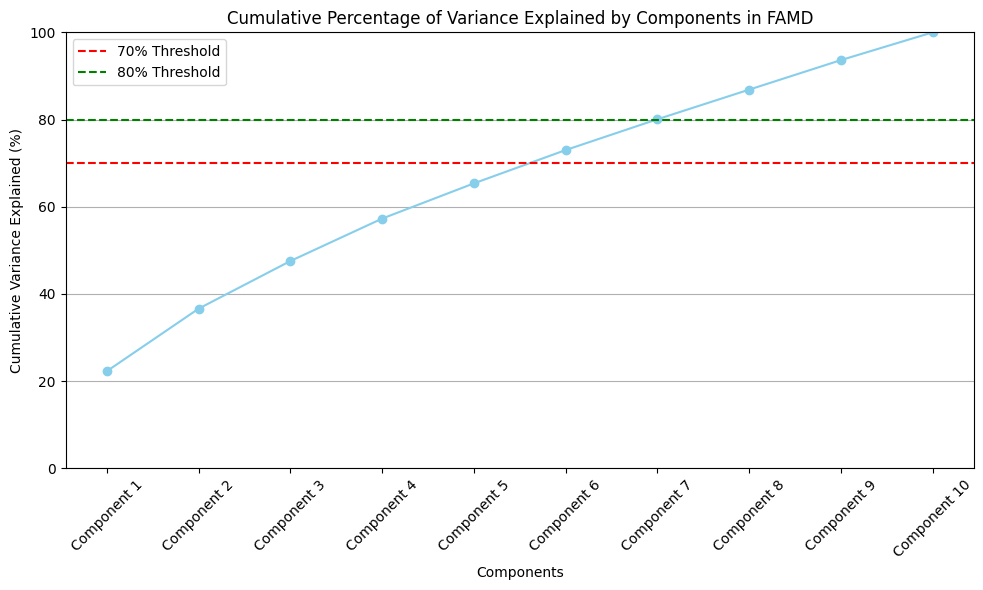

In [ ]:
total_eigenvalues = sum(eigenvalues)
variance_explained = [(eigenvalue / total_eigenvalues) * 100 for eigenvalue in eigenvalues]

cumulative_variance_explained = [sum(variance_explained[:i + 1]) for i in range(len(variance_explained))]

cumulative_variance_df = pd.DataFrame({
    'Component': [f'Component {i + 1}' for i in range(len(cumulative_variance_explained))],
    'Cumulative Variance Explained (%)': cumulative_variance_explained
})

plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance_df['Component'], cumulative_variance_df['Cumulative Variance Explained (%)'], marker='o', color='skyblue')
plt.title('Cumulative Percentage of Variance Explained by Components in FAMD')
plt.xlabel('Components')
plt.ylabel('Cumulative Variance Explained (%)')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.grid(axis='y')

plt.axhline(y=70, color='r', linestyle='--', label='70% Threshold')
plt.axhline(y=80, color='g', linestyle='--', label='80% Threshold')
plt.legend()
plt.tight_layout()
plt.show()


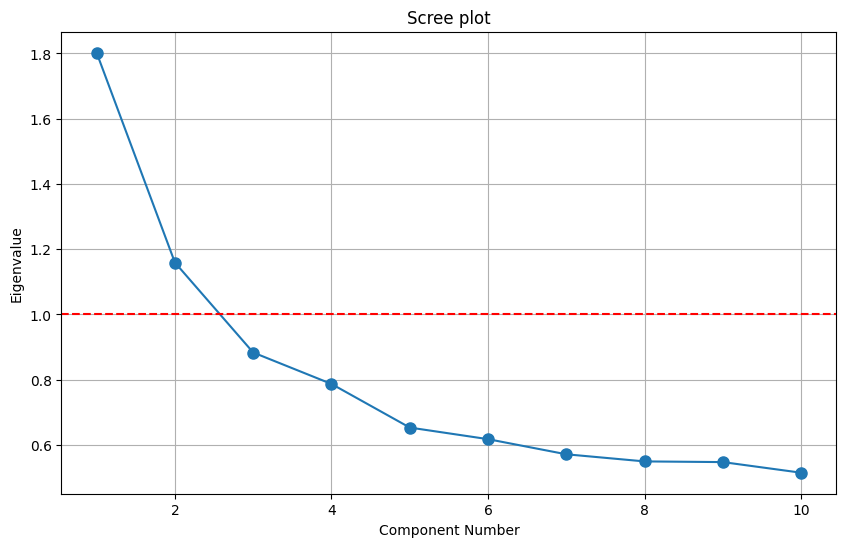

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(range(1,len(eigenvalues)+1),eigenvalues,'o-',markersize=8)
plt.axhline(y=1,color='r',linestyle='--')
plt.title('Scree plot')
plt.xlabel('Component Number')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.show()

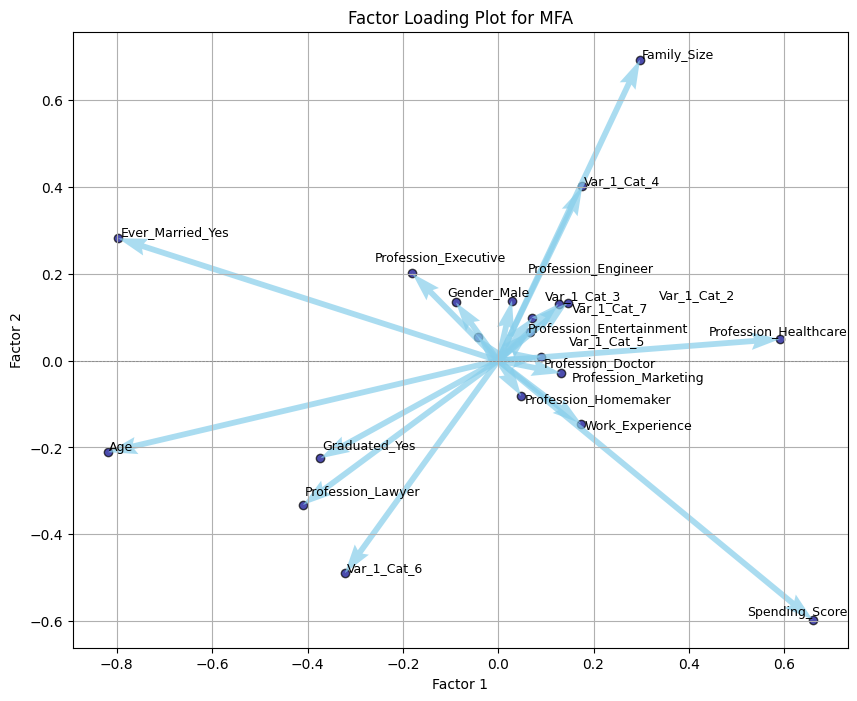

In [ ]:
row_coords = mfa.row_coordinates(X_train_scaled)
loadings = np.corrcoef(X_train_scaled.T,row_coords.T)[:X_train_scaled.shape[1],X_train_scaled.shape[1]:]
loadings_df = pd.DataFrame(loadings, index = X_train_scaled.columns,columns=[f'Factor {i+1}'for i in range(n_components)])
factor_loadings = loadings_df.iloc[:,:2]
plt.figure(figsize=(10,8))
plt.scatter(factor_loadings['Factor 1'],factor_loadings['Factor 2'],alpha=.7,color='darkblue',edgecolor='k')

for i in range(factor_loadings.shape[0]):
  plt.quiver(0,0,factor_loadings.iloc[i,0],factor_loadings.iloc[i,1],angles='xy',scale_units='xy',color='skyblue',scale=1,alpha=.7,linewidth=1.0)

texts = []
for i, variable in enumerate(loadings_df.index):
  texts.append(plt.text(factor_loadings.iloc[i,0],factor_loadings.iloc[i,1],variable,fontsize=9,color='black'))
adjust_text(texts)
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.title('Factor Loading Plot for MFA')
plt.axhline(0,color='grey',lw=.5,ls='')
plt.axhline(0,color='grey',lw=.5,ls='--')
plt.grid()
plt.show()


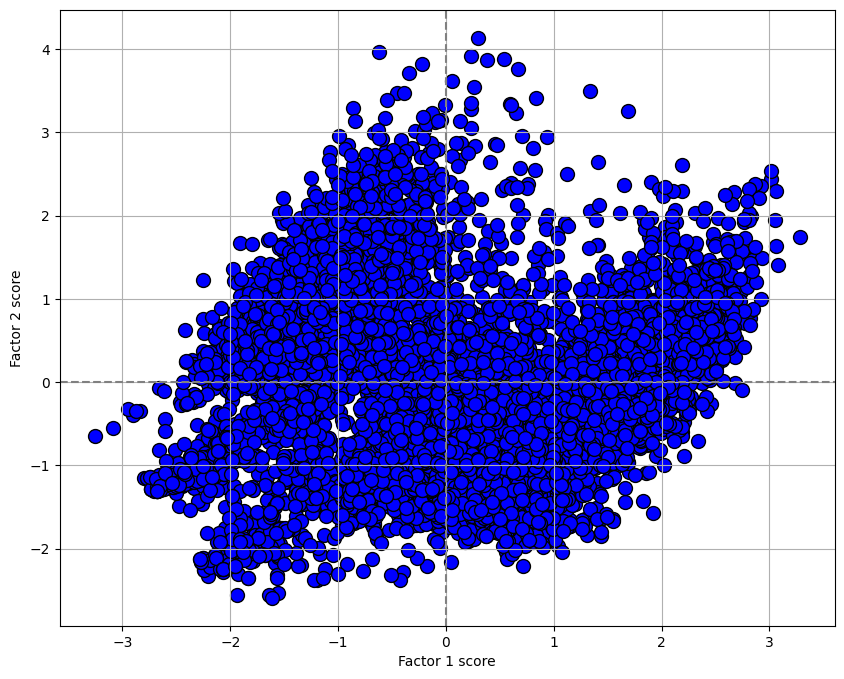

In [ ]:
factor_scores= mfa.transform(X_train_scaled).values
plt.figure(figsize=(10,8))
plt.scatter(factor_scores[:,0],factor_scores[:,1],color='blue',edgecolor='k',s=100)
plt.axhline(0,color='grey',linestyle='--')
plt.axvline(0,color='grey',linestyle='--')
plt.xlabel('Factor 1 score')
plt.ylabel('Factor 2 score')
plt.grid(True)
plt.show()

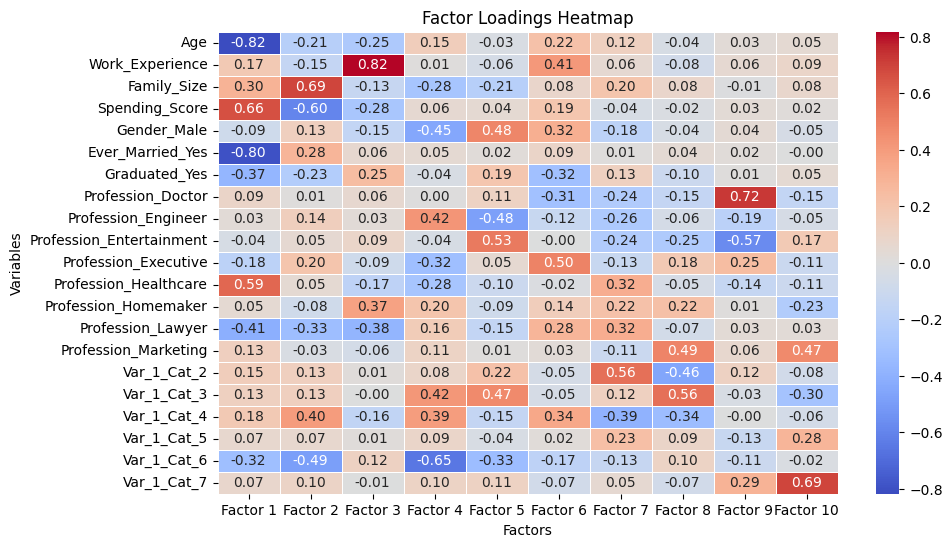

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(loadings_df, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title('Factor Loadings Heatmap')
plt.xlabel('Factors')
plt.ylabel('Variables')
plt.show()

### KPCA

In [30]:
gower_dist = gower_matrix(X_train_scaled)


In [ ]:
kpca = KernelPCA(n_components=10, kernel='rbf')
kpca = kpca.fit(gower_dist)

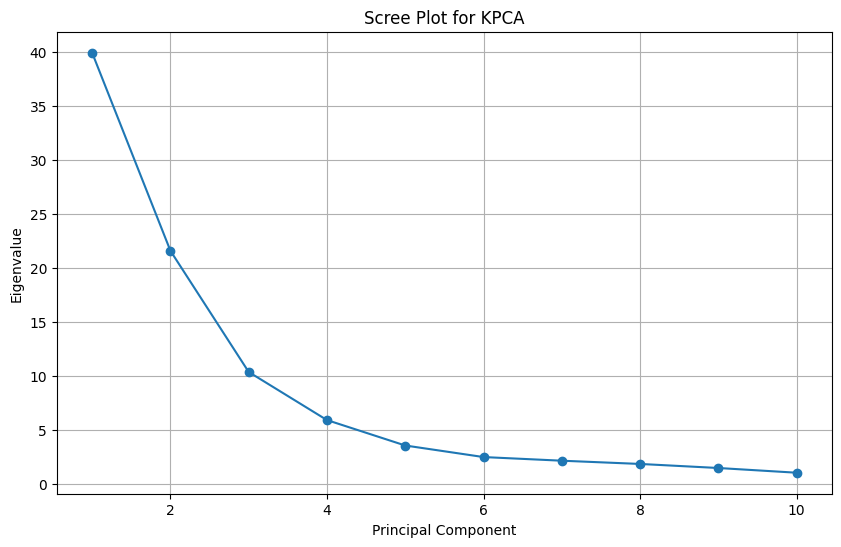

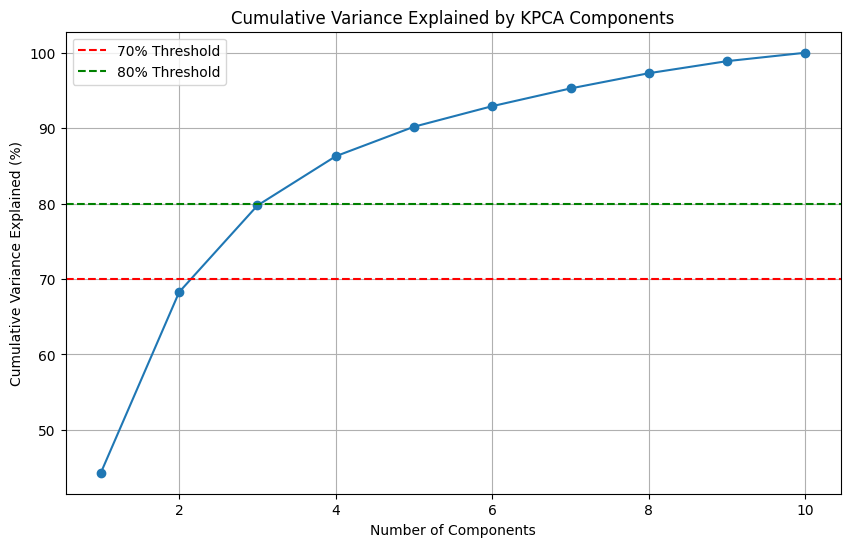

In [ ]:
eigenvalues = kpca.eigenvalues_

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o')
plt.title('Scree Plot for KPCA')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

cumulative_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues) * 100

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.title('Cumulative Variance Explained by KPCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained (%)')
plt.axhline(y=70, color='r', linestyle='--', label='70% Threshold')
plt.axhline(y=80, color='g', linestyle='--', label='80% Threshold')
plt.legend()
plt.grid()
plt.show()

Scatter plot KPCA

In [ ]:
kpca = KernelPCA(n_components=10, kernel='rbf')
X_kpca = kpca.fit_transform(gower_dist)

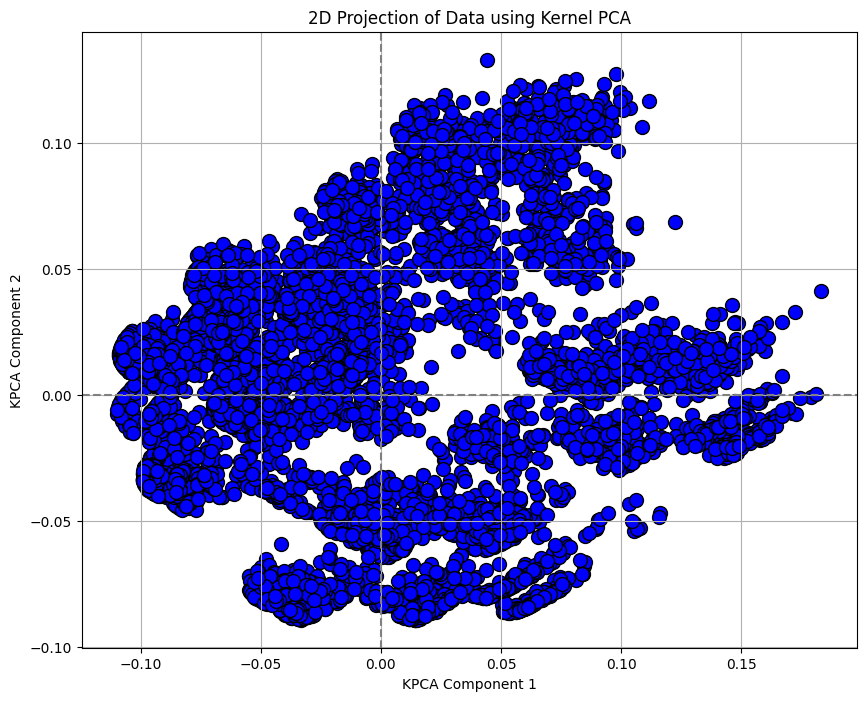

In [ ]:
X_kpca_2d = X_kpca[:, :2]
plt.figure(figsize=(10, 8))
plt.scatter(X_kpca_2d[:, 0], X_kpca_2d[:, 1], color='blue', edgecolor='k', s=100)
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.xlabel('KPCA Component 1')
plt.ylabel('KPCA Component 2')
plt.title('2D Projection of Data using Kernel PCA')
plt.grid(True)
plt.show()

Cluster analysis

In [ ]:
ordinal_encoded_columns = preprocessor.named_transformers_['ordinal'].get_feature_names_out()
ordinal_encoded_indices = [X_train.columns.get_loc(col) for col in ordinal_encoded_columns]
ordinal_encoded_indices

[3]

In [ ]:
nominal_encoded_columns= preprocessor.named_transformers_['nominal'].get_feature_names_out()
nominal_encoded_indices =[X_train.columns.get_loc(col) for col in nominal_encoded_columns]
nominal_encoded_indices

[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [ ]:
categorical_indices = ordinal_encoded_indices+nominal_encoded_indices

In [ ]:
gower_dist = gower_matrix(X_train_scaled)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/50, moves: 322, ncost: 29026.06505440646
Run: 1, iteration: 2/50, moves: 53, ncost: 29023.63424901569
Run: 1, iteration: 3/50, moves: 5, ncost: 29023.575628991566
Run: 1, iteration: 4/50, moves: 0, ncost: 29023.575628991566
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/50, moves: 1356, ncost: 29199.127249934627
Run: 2, iteration: 2/50, moves: 469, ncost: 29081.12240070451
Run: 2, iteration: 3/50, moves: 153, ncost: 29066.262888420762
Run: 2, iteration: 4/50, moves: 42, ncost: 29065.0172275477
Run: 2, iteration: 5/50, moves: 8, ncost: 29064.94642471528
Run: 2, iteration: 6/50, moves: 0, ncost: 29064.94642471528
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/50, moves: 1209, ncost: 29236.7738011205
Run: 3, 

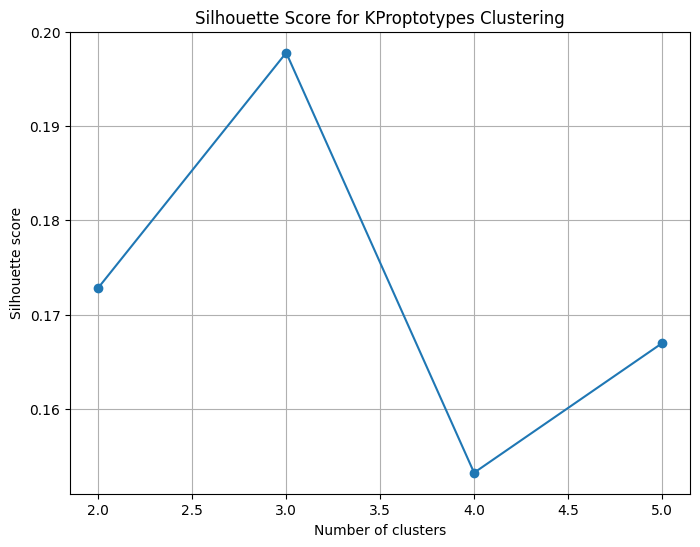

In [ ]:
range_n_clusters = [2,3,4,5]
silhouette_scores = []
for n_clusters in range_n_clusters:
  kproto = KPrototypes(n_clusters= n_clusters,init='Cao',n_init=5,verbose=1,max_iter=50)  # n_init=2 max_iter=20  optimal clusters=3
  cluster_labels_kproto = kproto.fit_predict(X_train_scaled.values,categorical = categorical_indices)

  silhouette_avg = silhouette_score(X_train_scaled, cluster_labels_kproto)
  silhouette_scores.append(silhouette_avg)

plt.figure(figsize =(8,6))
plt.plot(range_n_clusters,silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette Score for KProptotypes Clustering')
plt.grid(True)
plt.show()





In [ ]:
n_clusters = 3
kproto = KPrototypes(n_clusters = n_clusters, init='Cao',verbose=0)
cluster_labels_kproto = kproto.fit_predict(X_train_scaled.values, categorical = categorical_indices)



### KPCA on gower distance
kpca on gower distance matrix. Apply Kernel PCA (linear kernel) on the Gower distance matrix to reduce dimensionality.Visualize the K-Prototypes clustering labels in the reduced-dimensional space.

In [ ]:
kpca_kproto = KernelPCA(n_components = 2,kernel='linear')
X_kpca_kproto = kpca_kproto.fit_transform(gower_dist)

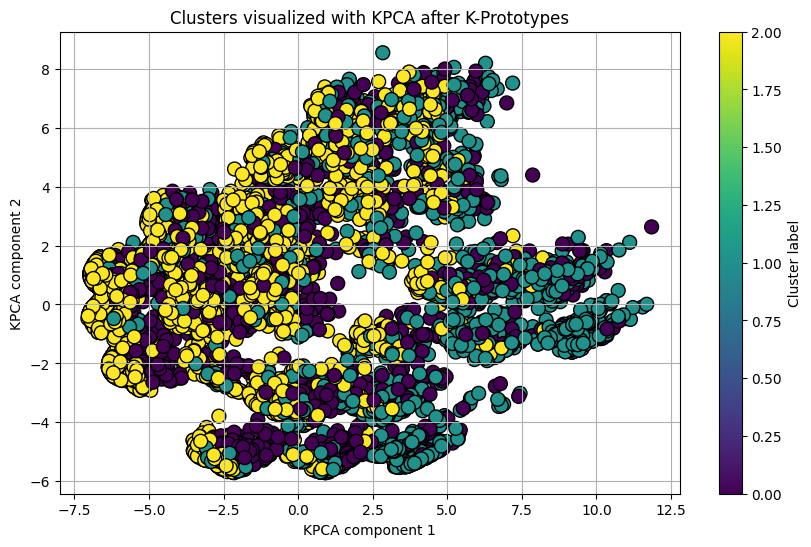

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(X_kpca_kproto[:,0],X_kpca_kproto[:,1],c=cluster_labels_kproto,cmap='viridis',edgecolor='k',s=100)
plt.title('Clusters visualized with KPCA after K-Prototypes')
plt.xlabel('KPCA component 1')
plt.ylabel('KPCA component 2')
plt.colorbar(label='Cluster label')
plt.grid()
plt.show()

Agglogmerative clustering

In [ ]:
n_clusters = 3
agg_clustering = AgglomerativeClustering(n_clusters= n_clusters, affinity='precomputed',linkage='average')
cluster_labels_agg = agg_clustering.fit_predict(gower_dist)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


<ipython-input-50-9409e1bc8834>:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = shc.linkage(gower_dist, method='ward')


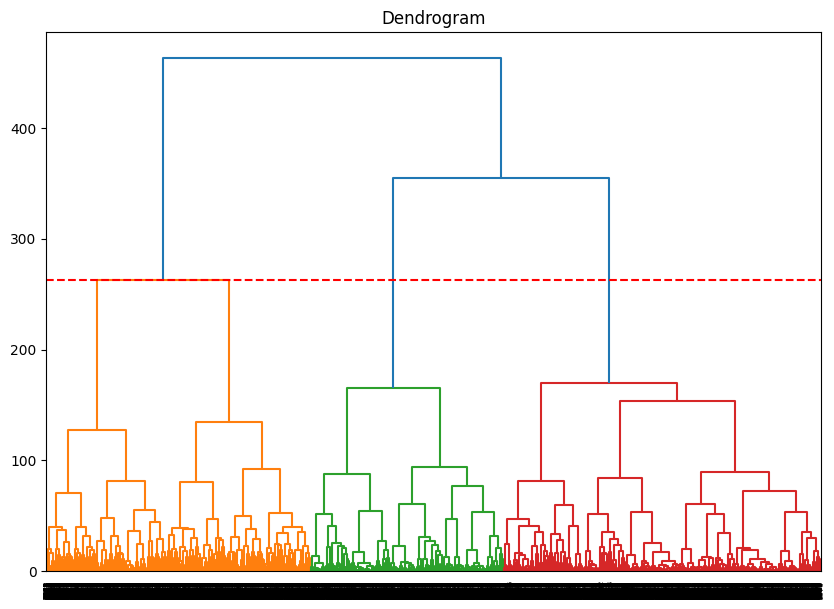

In [ ]:
max_d = 0
linkage_matrix = shc.linkage(gower_dist, method='ward')
for i in range(len(linkage_matrix)):
    if fcluster(linkage_matrix, linkage_matrix[i, 2], criterion='distance').max() == 3:
        max_d = linkage_matrix[i, 2]
        break

plt.figure(figsize=(10, 7))
plt.title('Dendrogram')
dend = shc.dendrogram(linkage_matrix)
plt.axhline(y=max_d, color='r', linestyle='--')
plt.show()

In [ ]:
silhouette_avg = silhouette_score(X_train_scaled, cluster_labels_agg)
print(f'Silhouette Score: {silhouette_avg:.3f}')

Silhouette Score: 0.057


visualize using dimenisnality reduction


In [ ]:
kpca_agg = KernelPCA(n_components = 2,kernel='linear')
X_kpca = kpca_agg.fit_transform(gower_dist)


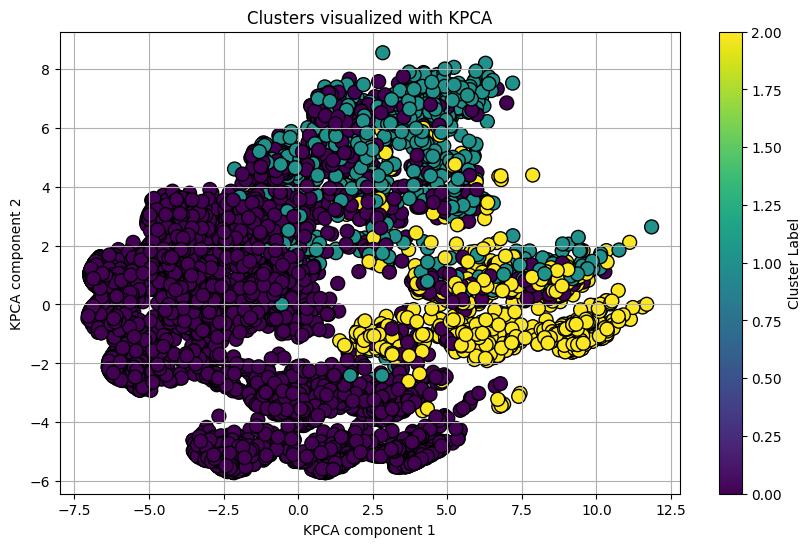

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(X_kpca[:,0],X_kpca[:,1],c=cluster_labels_agg,cmap='viridis',edgecolor='k',s=100)  ####change to cluster_labels_agg
plt.title('Clusters visualized with KPCA')
plt.xlabel('KPCA component 1')
plt.ylabel('KPCA component 2')
plt.colorbar(label='Cluster Label')
plt.grid()
plt.show()

HDBSCAN

In [31]:
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size = 250, min_samples=50)  #5, 100 ,400(custer size) #min samples  #outliers: 500,200  (6 clusters with outiers) (300,100)
cluster_labels_hdbscan = hdbscan_model.fit_predict(gower_dist)


In [32]:

kpca_hdbscan  = KernelPCA(n_components=2,kernel='linear')
X_kpca_hdbscan = kpca_hdbscan.fit_transform(gower_dist)

In [33]:
# Step 3: Get the number of clusters (excluding noise points labeled as -1)
num_clusters = len(set(cluster_labels_hdbscan)) - (1 if -1 in cluster_labels_hdbscan else 0)
print(f"The number of clusters identified by HDBSCAN is {num_clusters}")


The number of clusters identified by HDBSCAN is 11


In [35]:
# Cluster labels
print(f"Cluster labels: {np.unique(cluster_labels_hdbscan)}")

# Cluster sizes
cluster_sizes = np.bincount(cluster_labels_hdbscan[cluster_labels_hdbscan != -1])
print(f"Cluster sizes: {cluster_sizes}")

# Cluster persistence
cluster_persistence = hdbscan_model.cluster_persistence_
print(f"Cluster persistence: {cluster_persistence}")

# Outlier points
outlier_points = np.where(cluster_labels_hdbscan == -1)[0]
print(f"Number of outliers: {len(outlier_points)}")





Cluster labels: [-1  0  1  2  3  4  5  6  7  8  9 10]
Cluster sizes: [ 342  295  323  261  567  411  477  932  646  496 1415]
Cluster persistence: [0.00472894 0.00683816 0.00461895 0.00482163 0.03075835 0.09164214
 0.04230988 0.20611263 0.19026851 0.04243288 0.2573602 ]
Number of outliers: 1903


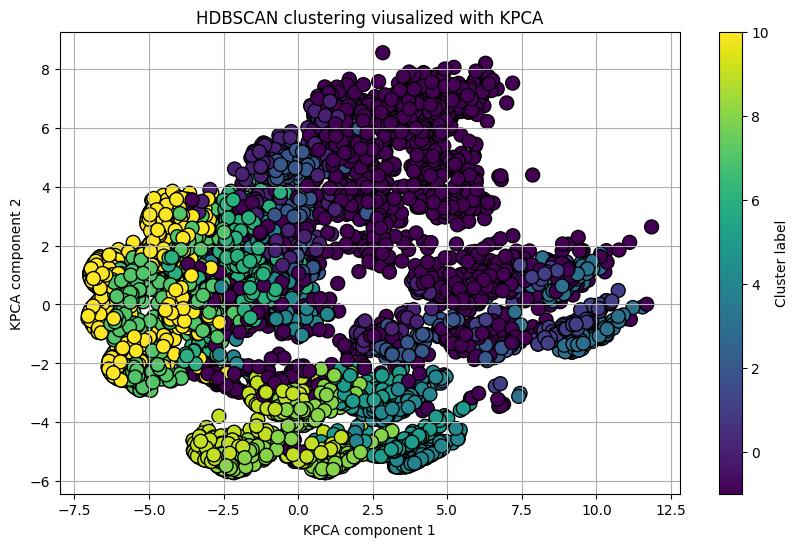

In [ ]:
plt.figure(figsize=(10,6))
scatter = plt.scatter(X_kpca_hdbscan[:,0],X_kpca_hdbscan[:,1], c= cluster_labels_hdbscan,cmap='viridis',edgecolor='k',s=100)
plt.title('HDBSCAN clustering viusalized with KPCA')
plt.xlabel('KPCA component 1')
plt.ylabel('KPCA component 2')
plt.colorbar(scatter, label='Cluster label')
plt.grid()
plt.show()